In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import (
        AddMissingIndicator,
        MeanMedianImputer,
        CategoricalImputer)

from feature_engine.encoding import (
        RareLabelEncoder,
        OrdinalEncoder)

from feature_engine.transformation import (
        LogTransformer,
        YeoJohnsonTransformer)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

pd.pandas.set_option('display.max_columns', None)


In [3]:
# Load dataset
data = pd.read_csv('..\MLDeploy\AmesHousing.csv')
print(data.shape)
data.head()

(2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Order','PID', 'SalePrice'], axis=1), # predictive variables
    data['SalePrice'], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((2344, 79), (586, 79))

In [5]:
# Log transform the target

y_train = np.log(y_train)
y_test = np.log(y_test)

In [6]:
cat_vars = [var for var in data.columns if data[var].dtype=='O']

cat_vars = cat_vars + ['MS SubClass']

X_train[cat_vars]=X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

In [7]:
cat_vars_with_na = [var for var in cat_vars if X_train[var].isnull().sum()>0]

X_train[cat_vars_with_na].isnull().mean().sort_values(ascending=False)

Pool QC           0.994881
Misc Feature      0.963311
Alley             0.934727
Fence             0.796928
Fireplace Qu      0.487201
Garage Finish     0.056314
Garage Qual       0.056314
Garage Cond       0.056314
Garage Type       0.055461
Bsmt Exposure     0.030290
BsmtFin Type 2    0.029437
Bsmt Qual         0.029010
Bsmt Cond         0.029010
BsmtFin Type 1    0.029010
Mas Vnr Type      0.007679
Electrical        0.000427
dtype: float64

In [8]:
with_string_missing=[var for var in cat_vars_with_na if X_train[var].isnull().mean()>0.1]
with_frequent_category = [var for var in cat_vars_with_na if X_train[var].isnull().mean()<0.1]

In [9]:
with_string_missing

['Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']

In [10]:
with_frequent_category

['Mas Vnr Type',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Electrical',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond']

In [11]:
# replace the missing values with 'Missing'
cat_imputer_missing = CategoricalImputer(
        imputation_method = 'missing', variables=with_string_missing)

cat_imputer_missing.fit(X_train)

cat_imputer_missing.imputer_dict_

{'Alley': 'Missing',
 'Fireplace Qu': 'Missing',
 'Pool QC': 'Missing',
 'Fence': 'Missing',
 'Misc Feature': 'Missing'}

In [12]:
X_train = cat_imputer_missing.transform(X_train)
X_test = cat_imputer_missing.transform(X_test)

In [13]:
cat_imputer_frequent = CategoricalImputer(
            imputation_method='frequent',variables=with_frequent_category)

cat_imputer_frequent.fit(X_train)
cat_imputer_frequent.imputer_dict_

{'Mas Vnr Type': 'None',
 'Bsmt Qual': 'TA',
 'Bsmt Cond': 'TA',
 'Bsmt Exposure': 'No',
 'BsmtFin Type 1': 'GLQ',
 'BsmtFin Type 2': 'Unf',
 'Electrical': 'SBrkr',
 'Garage Type': 'Attchd',
 'Garage Finish': 'Unf',
 'Garage Qual': 'TA',
 'Garage Cond': 'TA'}

In [14]:
X_train = cat_imputer_frequent.transform(X_train)
X_test = cat_imputer_frequent.transform(X_test)

In [15]:
[var for var in cat_vars_with_na if X_train[var].isnull().sum()>0]

[]

In [16]:
X_test[cat_vars_with_na].isnull().sum()

Alley             0
Mas Vnr Type      0
Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     0
BsmtFin Type 1    0
BsmtFin Type 2    0
Electrical        0
Fireplace Qu      0
Garage Type       0
Garage Finish     0
Garage Qual       0
Garage Cond       0
Pool QC           0
Fence             0
Misc Feature      0
dtype: int64

In [17]:
num_vars= [var for var in X_train.columns if var not in cat_vars and var !='SalePrice']

len(num_vars)

35

In [18]:
num_vars_with_na = [var for var in num_vars if 
                   X_train[var].isnull().sum()>0]

X_train[num_vars_with_na].isnull().mean().sort_values(ascending=False)

Lot Frontage      0.174488
Garage Yr Blt     0.056314
Mas Vnr Area      0.007679
Bsmt Full Bath    0.000853
Bsmt Half Bath    0.000853
BsmtFin SF 1      0.000427
BsmtFin SF 2      0.000427
Bsmt Unf SF       0.000427
Total Bsmt SF     0.000427
Garage Cars       0.000427
Garage Area       0.000427
dtype: float64

In [19]:
missing_ind = AddMissingIndicator(variables=num_vars_with_na)

missing_ind.fit(X_train)

X_train = missing_ind.transform(X_train)
X_test = missing_ind.transform(X_test)

In [20]:
X_train[['Lot Frontage_na',
 'Mas Vnr Area_na',
 'BsmtFin SF 1_na',
 'BsmtFin SF 2_na',
 'Bsmt Unf SF_na',
 'Total Bsmt SF_na',
 'Bsmt Full Bath_na',
 'Bsmt Half Bath_na',
 'Garage Yr Blt_na',
 'Garage Cars_na',
 'Garage Area_na']].head()

,Lot Frontage_na,Mas Vnr Area_na,BsmtFin SF 1_na,BsmtFin SF 2_na,Bsmt Unf SF_na,Total Bsmt SF_na,Bsmt Full Bath_na,Bsmt Half Bath_na,Garage Yr Blt_na,Garage Cars_na,Garage Area_na
2073,0,0,0,0,0,0,0,0,0,0,0
2754,0,0,0,0,0,0,0,0,0,0,0
1282,0,0,0,0,0,0,0,0,0,0,0
1572,1,0,0,0,0,0,0,0,0,0,0
641,0,0,0,0,0,0,0,0,0,0,0


In [21]:
mean_imputer = MeanMedianImputer(
                imputation_method='mean', variables=num_vars_with_na)

mean_imputer.fit(X_train)

X_train = mean_imputer.transform(X_train)
X_test = mean_imputer.transform(X_test)

In [22]:
mean_imputer.imputer_dict_

{'Lot Frontage': 69.1875968992248,
 'Mas Vnr Area': 102.17669819432503,
 'BsmtFin SF 1': 444.4835680751174,
 'BsmtFin SF 2': 51.93854033290653,
 'Bsmt Unf SF': 554.3585147247119,
 'Total Bsmt SF': 1050.7806231327359,
 'Bsmt Full Bath': 0.4372331340734415,
 'Bsmt Half Bath': 0.060204953031596925,
 'Garage Yr Blt': 1977.9046112115732,
 'Garage Cars': 1.7618437900128041,
 'Garage Area': 471.8113529662825}

In [23]:
[var for var in num_vars_with_na if X_test[var].isnull().sum()>0]

[]

In [24]:
def elapsed_year(df,var):
    df[var] = df['Yr Sold']-df[var]
    return df

In [25]:
for var in ['Year Built', 'Year Remod/Add', 'Garage Yr Blt']:
    X_train = elapsed_year(X_train, var)
    X_test = elapsed_year(X_test,var)

In [26]:
drop_features = DropFeatures(features_to_drop=['Yr Sold'])

X_train = drop_features.fit_transform(X_train)
X_test = drop_features.transform(X_test)

In [27]:
log_transformer = LogTransformer(variables=['Lot Frontage',
                                           '1st Flr SF', 
                                           'Gr Liv Area'])

X_train = log_transformer.fit_transform(X_train)
X_test = log_transformer.transform(X_test)

In [28]:
yeo_transformer = YeoJohnsonTransformer(variables=['Lot Area'])

X_train = yeo_transformer.fit_transform(X_train)
X_test = yeo_transformer.transform(X_test)

yeo_transformer.lambda_dict_

{'Lot Area': 0.10674834539872138}

In [29]:
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [30]:
[var for var in X_test.columns if X_test[var].isnull().sum()>0]

[]

In [31]:
skewed = ['BsmtFin SF 2', 'Low Qual Fin SF', 'Enclosed Porch',
    '3Ssn Porch', 'Screen Porch', 'Misc Val']

binarizer = SklearnTransformerWrapper(
            transformer=Binarizer(threshold=0), variables=skewed)

X_train = binarizer.fit_transform(X_train)
X_test = binarizer.transform(X_test)

X_train[skewed].head()

,BsmtFin SF 2,Low Qual Fin SF,Enclosed Porch,3Ssn Porch,Screen Porch,Misc Val
2073,0.0,0.0,0.0,0.0,1.0,0.0
2754,0.0,0.0,0.0,0.0,0.0,0.0
1282,0.0,0.0,0.0,0.0,0.0,0.0
1572,1.0,0.0,1.0,0.0,0.0,0.0
641,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
             'Heating QC', 'Kitchen Qual', 'Fireplace Qu',
             'Garage Qual', 'Garage Cond',]

for var in qual_vars:
    X_train[var]=X_train[var].map(qual_mappings)
    X_test[var]=X_test[var].map(qual_mappings)

In [33]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'Bsmt Exposure'
X_train[var] = X_train[var].map(exposure_mappings)
X_test[var]=X_test[var].map(exposure_mappings)


In [34]:
finish_mappings={'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFin Type 1', 'BsmtFin Type 2']

for var in finish_vars:
    X_train[var] = X_train[var].map(finish_mappings)
    X_test[var] = X_test[var].map(finish_mappings)

In [35]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'Garage Finish'

X_train[var] = X_train[var].map(garage_mappings)
X_test[var] = X_test[var].map(garage_mappings)

In [36]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

X_train[var] = X_train[var].map(fence_mappings)
X_test[var] = X_test[var].map(fence_mappings)

In [37]:
[var for var in X_train.columns if X_train[var].isnull().sum()>0]

[]

In [42]:
[var for var in X_test.columns if X_test[var].isnull().sum()>0]

[]

In [43]:
qual_vars = qual_vars + finish_vars + ['Bsmt Exposure','Garage Finish','Fence']

cat_others = [var for var in cat_vars if var not in qual_vars]

len(cat_others)

30

In [44]:
rare_encoder = RareLabelEncoder(tol=0.01, n_categories=1, variables=
                               cat_others)

rare_encoder.fit(X_train)

rare_encoder.encoder_dict_

{'MS Zoning': Index(['RL', 'RM', 'FV'], dtype='object'),
 'Street': Index(['Pave'], dtype='object'),
 'Alley': Index(['Missing', 'Grvl', 'Pave'], dtype='object'),
 'Lot Shape': Index(['Reg', 'IR1', 'IR2'], dtype='object'),
 'Land Contour': Index(['Lvl', 'HLS', 'Bnk', 'Low'], dtype='object'),
 'Utilities': Index(['AllPub'], dtype='object'),
 'Lot Config': Index(['Inside', 'Corner', 'CulDSac', 'FR2'], dtype='object'),
 'Land Slope': Index(['Gtl', 'Mod'], dtype='object'),
 'Neighborhood': Index(['NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'NridgHt',
        'Sawyer', 'Gilbert', 'NWAmes', 'SawyerW', 'Mitchel', 'BrkSide',
        'Crawfor', 'IDOTRR', 'Timber', 'NoRidge', 'ClearCr', 'StoneBr', 'SWISU',
        'MeadowV', 'BrDale'],
       dtype='object'),
 'Condition 1': Index(['Norm', 'Feedr', 'Artery', 'RRAn', 'PosN'], dtype='object'),
 'Condition 2': Index(['Norm'], dtype='object'),
 'Bldg Type': Index(['1Fam', 'TwnhsE', 'Twnhs', 'Duplex', '2fmCon'], dtype='object'),
 'House Styl

In [45]:
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

In [48]:
cat_encoder = OrdinalEncoder(encoding_method='ordered', variables=cat_others)

cat_encoder.fit(X_train, y_train)

cat_encoder.encoder_dict_

{'MS Zoning': {'Rare': 0, 'RM': 1, 'RL': 2, 'FV': 3},
 'Street': {'Rare': 0, 'Pave': 1},
 'Alley': {'Grvl': 0, 'Missing': 1, 'Pave': 2},
 'Lot Shape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
 'Land Contour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
 'Utilities': {'Rare': 0, 'AllPub': 1},
 'Lot Config': {'Inside': 0, 'Corner': 1, 'FR2': 2, 'Rare': 3, 'CulDSac': 4},
 'Land Slope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
 'Neighborhood': {'IDOTRR': 0,
  'MeadowV': 1,
  'BrDale': 2,
  'OldTown': 3,
  'BrkSide': 4,
  'Edwards': 5,
  'SWISU': 6,
  'Sawyer': 7,
  'NAmes': 8,
  'Mitchel': 9,
  'SawyerW': 10,
  'NWAmes': 11,
  'Rare': 12,
  'Gilbert': 13,
  'CollgCr': 14,
  'Crawfor': 15,
  'ClearCr': 16,
  'Somerst': 17,
  'Timber': 18,
  'StoneBr': 19,
  'NridgHt': 20,
  'NoRidge': 21},
 'Condition 1': {'Artery': 0,
  'Feedr': 1,
  'Rare': 2,
  'Norm': 3,
  'RRAn': 4,
  'PosN': 5},
 'Condition 2': {'Rare': 0, 'Norm': 1},
 'Bldg Type': {'2fmCon': 0, 'Twnhs': 1, 'Duplex': 2, '1Fam': 3, 'TwnhsE': 4

In [49]:
X_train = cat_encoder.transform(X_train)
X_test = cat_encoder.transform(X_test)

In [50]:
[var for var in X_train.columns if X_train[var].isnull().sum()>0]

[]

In [51]:
[var for var in X_test.columns if X_test[var].isnull().sum()>0]

[]

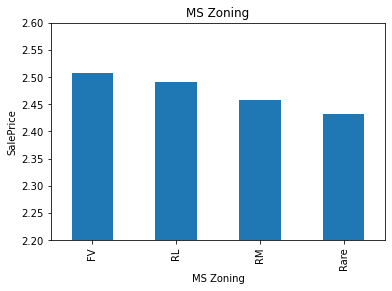

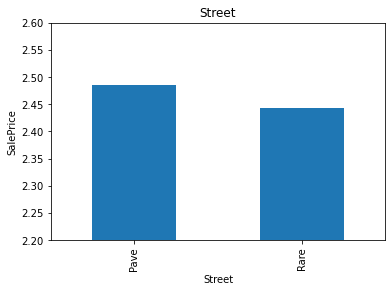

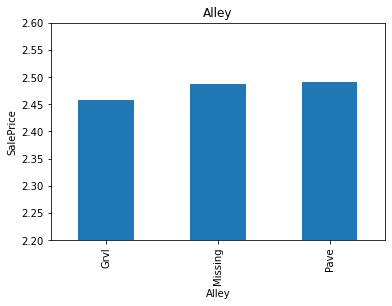

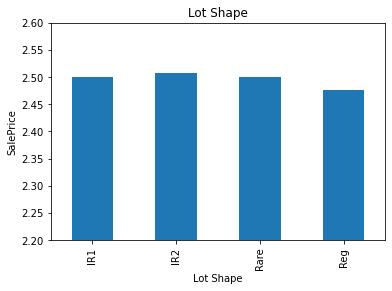

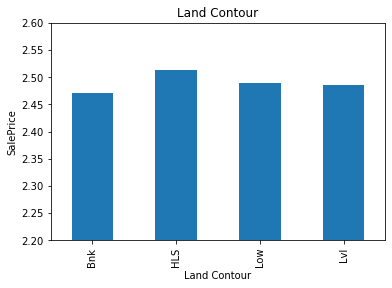

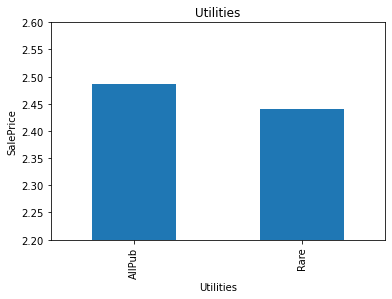

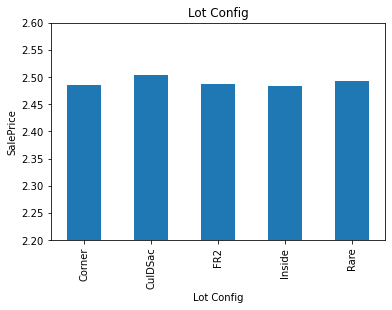

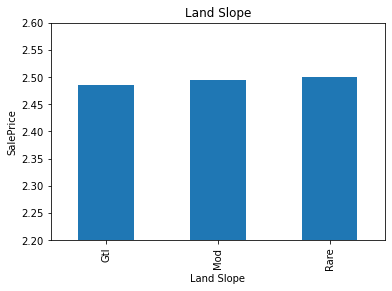

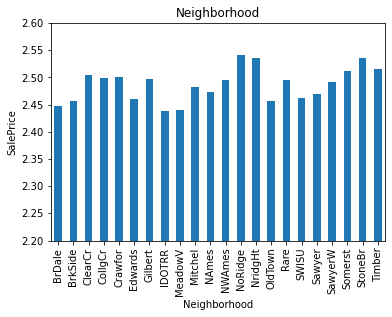

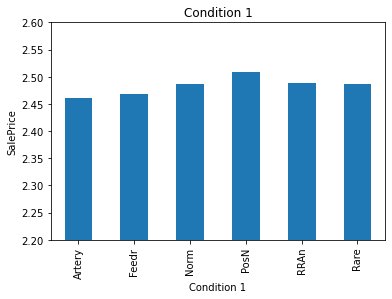

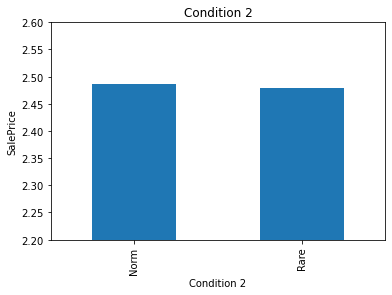

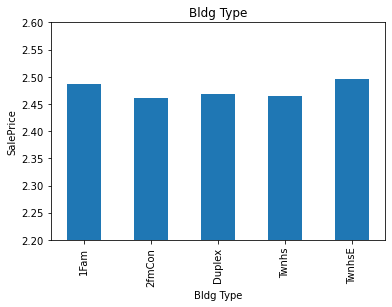

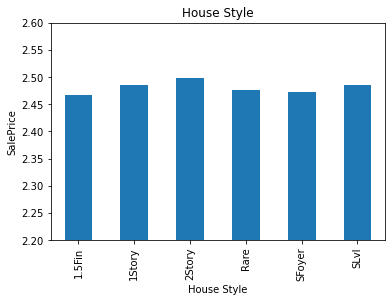

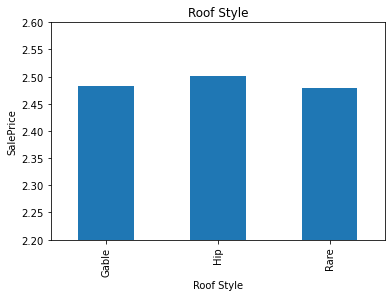

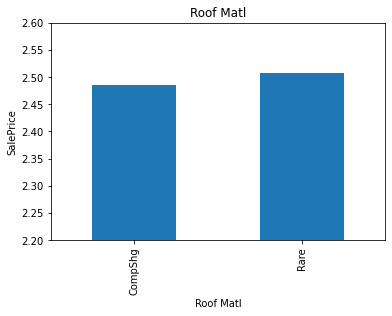

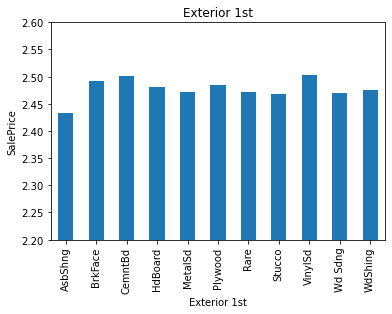

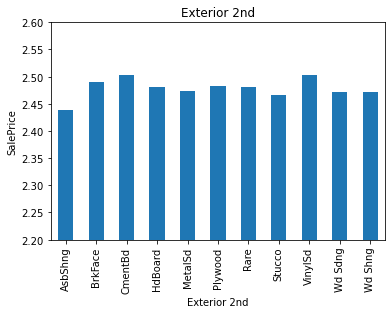

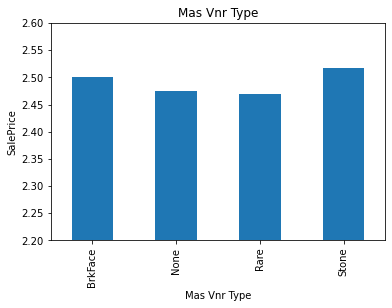

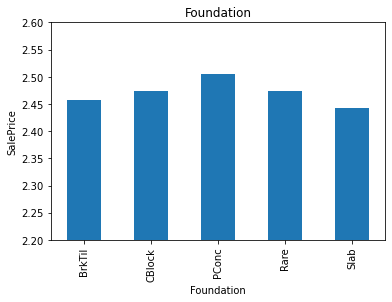

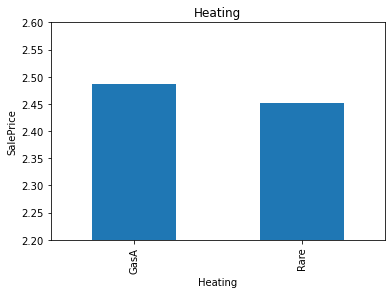

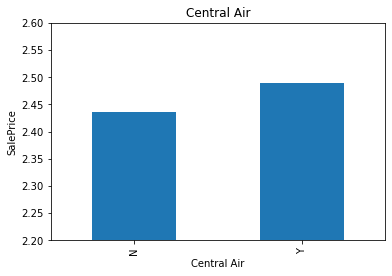

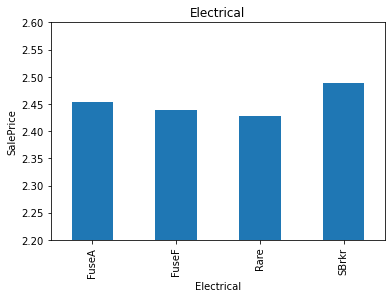

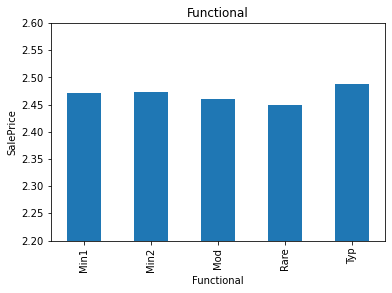

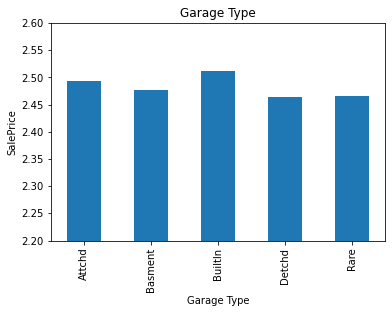

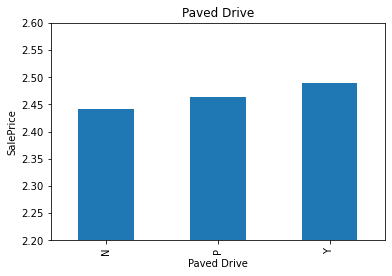

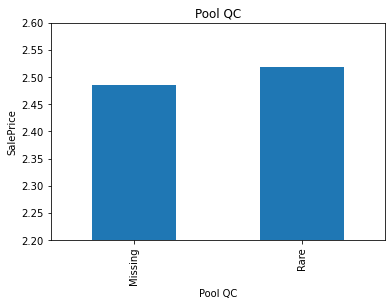

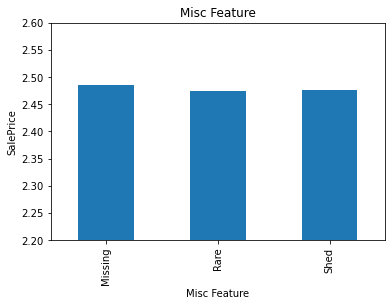

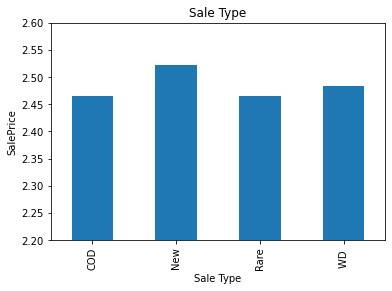

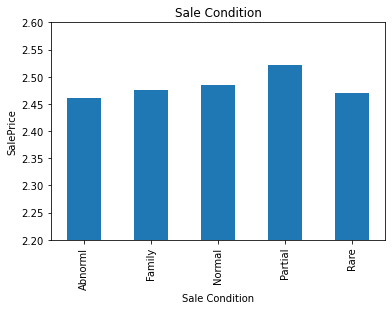

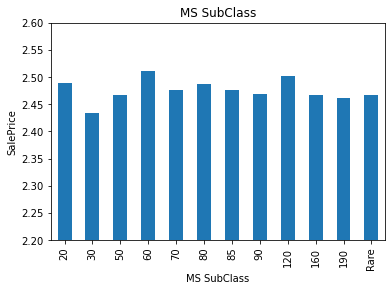

In [46]:
def analyse_var(train, y_train, var):
    tmp = pd.concat([train,np.log(y_train)], axis=1)
    tmp.groupby(var)['SalePrice'].mean().plot.bar()
    plt.title(var)
    plt.ylim(2.2,2.6)
    plt.ylabel('SalePrice')
    plt.show()
    
for var in cat_others:
    analyse_var(X_train, y_train, var)

In [53]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [54]:
X_train.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Sale Type,Sale Condition,Lot Frontage_na,Mas Vnr Area_na,BsmtFin SF 1_na,BsmtFin SF 2_na,Bsmt Unf SF_na,Total Bsmt SF_na,Bsmt Full Bath_na,Bsmt Half Bath_na,Garage Yr Blt_na,Garage Cars_na,Garage Area_na
0,1.000000,0.666667,0.566384,0.323632,1.0,0.5,0.333333,0.333333,1.0,0.25,0.0,0.761905,0.6,1.0,0.75,1.0,0.555556,0.500,0.148438,0.311475,0.5,0.0,0.7,0.7,0.666667,0.167500,0.666667,0.5,1.0,0.75,0.5,0.000000,1.0,0.147236,0.0,0.0,0.136986,0.188380,1.0,0.5,1.0,1.0,0.472465,0.433898,0.0,0.643585,0.000000,0.5,0.50,0.5,0.500,0.333333,0.50,0.500000,1.0,0.25,0.6,0.75,0.697452,0.0,0.50,0.350134,0.5,0.50,1.0,0.000000,0.307278,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.727273,0.666667,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.818182,0.666667,0.521833,0.344511,1.0,0.5,0.333333,0.333333,1.0,0.00,0.0,0.666667,0.6,1.0,0.75,0.6,0.666667,0.500,0.007812,0.016393,0.5,0.0,1.0,0.9,0.666667,0.150000,0.666667,0.5,1.0,0.75,0.5,0.666667,1.0,0.003544,0.0,0.0,0.682363,0.264157,1.0,1.0,1.0,1.0,0.596157,0.000000,0.0,0.557273,0.000000,0.0,0.50,0.0,0.375,0.333333,0.75,0.416667,1.0,0.00,0.0,0.75,0.640127,0.5,0.75,0.581317,0.5,0.50,1.0,0.101124,0.079515,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.545455,1.000000,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.818182,0.666667,0.440313,0.272448,1.0,0.5,0.000000,0.333333,1.0,0.00,0.0,0.380952,1.0,1.0,0.75,0.6,0.444444,0.500,0.351562,0.754098,0.5,0.0,0.2,0.2,0.333333,0.000000,0.333333,0.5,0.5,0.50,0.5,0.000000,0.0,0.000000,0.0,0.0,0.478168,0.182815,1.0,1.0,1.0,1.0,0.456868,0.000000,0.0,0.427069,0.000000,0.0,0.25,0.0,0.375,0.333333,0.50,0.333333,1.0,0.00,0.0,0.75,0.780255,0.0,0.25,0.177419,0.5,0.50,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.363636,0.000000,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.818182,0.666667,0.441318,0.406690,1.0,0.5,0.333333,0.333333,1.0,0.25,0.0,0.857143,0.6,1.0,0.75,0.6,0.777778,0.625,0.250000,0.540984,1.0,1.0,0.4,0.5,0.333333,0.000000,0.666667,0.5,0.5,0.75,0.5,0.666667,0.8,0.206414,0.2,1.0,0.000000,0.256137,1.0,0.5,1.0,1.0,0.817656,0.000000,0.0,0.764325,0.333333,0.0,0.50,0.0,0.250,0.333333,0.75,0.666667,1.0,0.25,0.8,0.75,0.738854,1.0,0.50,0.446909,0.5,0.50,1.0,0.000000,0.097035,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.363636,0.000000,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.454545,0.666667,0.476078,0.313207,1.0,0.5,0.000000,0.333333,1.0,0.00,0.0,0.380952,0.6,1.0,0.50,0.6,0.444444,0.375,0.398438,0.852459,1.0,0.0,0.2,0.2,0.666667,0.410625,0.333333,0.5,1.0,0.50,0.5,0.000000,0.0,0.000000,0.0,0.0,0.798801,0.305401,1.0,1.0,1.0,1.0,0.651061,0.000000,0.0,0.608596,0.000000,0.0,0.50,0.0,0.500,0.666667,0.50,0.500000,1.0,0.00,0.0,0.00,0.799363,0.0,0.50,0.332661,0.5,0.25,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.666667,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
